In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    log_likelihood = -np.log(y_pred[range(m), y_true])
    loss = np.sum(log_likelihood) / m
    return loss


def one_hot_encode(y, num_classes):
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    one_hot[np.arange(m), y] = 1
    return one_hot


def train_neural_network(X, y, hidden_layer_sizes, learning_rate, epochs, seed=42):
    # 设置种子
    np.random.seed(seed)

    input_size = X.shape[1]
    output_size = len(np.unique(y))
    num_layers = len(hidden_layer_sizes) + 1
    losses = []

    # 初始化权重和偏差
    weights = [np.random.randn(input_size, hidden_layer_sizes[0])]
    biases = [np.zeros((1, hidden_layer_sizes[0]))]
    for i in range(1, num_layers - 1):
        weights.append(np.random.randn(hidden_layer_sizes[i - 1], hidden_layer_sizes[i]))
        biases.append(np.zeros((1, hidden_layer_sizes[i])))
    weights.append(np.random.randn(hidden_layer_sizes[-1], output_size))
    biases.append(np.zeros((1, output_size)))

    for epoch in range(epochs):
        # 前向传播
        layer_outputs = [X]
        for i in range(num_layers):
            layer_inputs = layer_outputs[-1] @ weights[i] + biases[i]
            if i == num_layers - 1:
                layer_outputs.append(softmax(layer_inputs))
            else:
                layer_outputs.append(sigmoid(layer_inputs))

        # 计算损失
        loss = cross_entropy_loss(y, layer_outputs[-1])
        losses.append(loss)

        # 反向传播
        errors = [layer_outputs[-1] - one_hot_encode(y, output_size)]
        for i in range(num_layers - 2, -1, -1):
            errors.insert(0, errors[0] @ weights[i + 1].T * sigmoid_derivative(layer_outputs[i + 1]))

        # 更新权重和偏差
        for i in range(num_layers):
            weights[i] -= learning_rate * layer_outputs[i].T @ errors[i]
            biases[i] -= learning_rate * np.sum(errors[i], axis=0, keepdims=True)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return weights, biases, losses


def predict(X, weights, biases):
    num_layers = len(weights)
    layer_outputs = [X]
    for i in range(num_layers):
        layer_inputs = layer_outputs[-1] @ weights[i] + biases[i]
        if i == num_layers - 1:
            layer_outputs.append(softmax(layer_inputs))
        else:
            layer_outputs.append(sigmoid(layer_inputs))
    return np.argmax(layer_outputs[-1], axis=1)


In [2]:
# 数据准备
# 加载Iris数据集
iris = load_iris()
X, y = iris.data, iris.target

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape, y.shape

((150, 4), (150,))

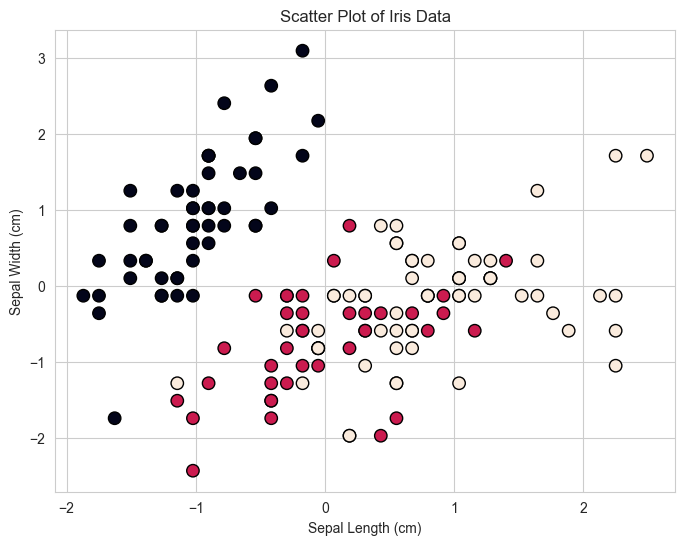

In [13]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=80, linewidth=1)
plt.title('Scatter Plot of Iris Data')
plt.xlabel('Sepal Length (cm)')
plt.ylabel('Sepal Width (cm)')
plt.show()


In [3]:
# 把第一类设为1，其余两类设为-1
y_1 = np.where(y == 0, 1, -1)
X_1 = X[:, :2]

# 初始化感知器参数
w = np.zeros(X_1.shape[1])
b = 0
learning_rate = 0.1
max_epochs = 1000  # 设置最大迭代次数

# 训练感知器
converged = False
for epoch in range(max_epochs):
    misclassified = False
    for xi, target in zip(X_1, y_1):
        if target * (np.dot(xi, w) + b) <= 0:
            w += learning_rate * target * xi
            b += learning_rate * target
            misclassified = True
    if not misclassified:
        converged = True
        break

# 打印感知器参数
if converged:
    print("感知器收敛.")
    print("感知器权重:", w)
    print("感知器阈值:", b)
else:
    print("感知器未收敛，达到最大迭代次数.")


感知器收敛.
感知器权重: [-0.45680287  0.22375126]
感知器阈值: -0.30000000000000004


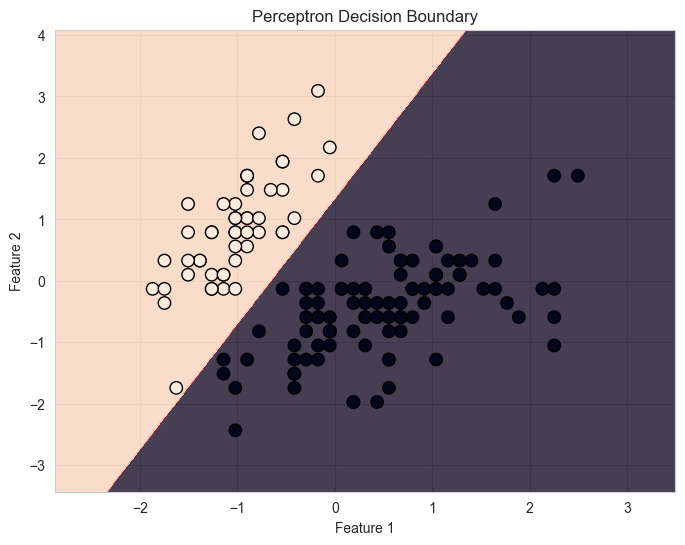

In [4]:
import matplotlib.pyplot as plt

# 定义一个函数来绘制决策边界
def plot_decision_boundary(X, y, w, b):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w) + b
    Z = np.sign(Z)
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=80, linewidth=1)

# 可视化决策边界
plt.figure(figsize=(8, 6))
plot_decision_boundary(X_1, y_1, w, b)
plt.title('Perceptron Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


In [10]:
# 把第二类设为1，其余设为-1
y_2 = y[y != 0]
X_2 = X[y != 0, :2]
y_2 = np.where(y_2 != 1, -1, 1)

# 初始化感知器参数
w = np.zeros(X_2.shape[1])
b = 0
learning_rate = 0.1
max_epochs = 1000  # 设置最大迭代次数

# 训练感知器
converged = False
for epoch in range(max_epochs):
    misclassified = False
    for xi, target in zip(X_2, y_2):
        if target * (np.dot(xi, w) + b) <= 0:
            w += learning_rate * target * xi
            b += learning_rate * target
            misclassified = True
    if not misclassified:
        converged = True
        break

# 打印感知器参数
if converged:
    print("感知器收敛.")
    print("感知器权重:", w)
    print("感知器阈值:", b)
else:
    print("感知器未收敛，达到最大迭代次数.")

感知器未收敛，达到最大迭代次数.


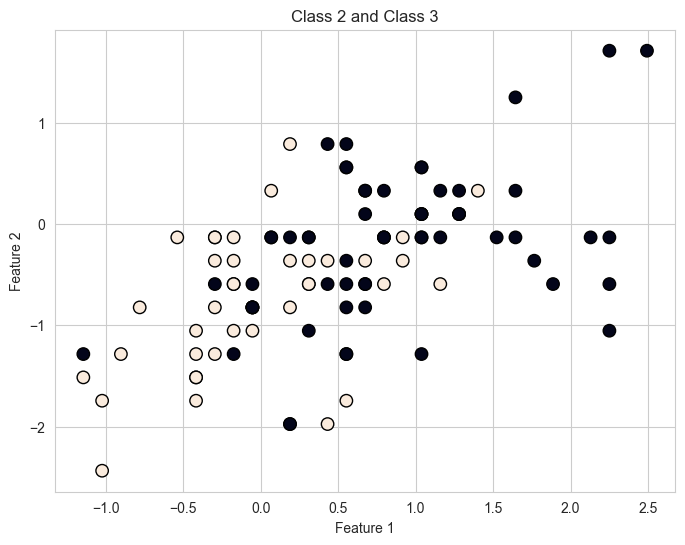

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(X_2[:, 0], X_2[:, 1], c=y_2, edgecolors='k', marker='o', s=80, linewidth=1)
plt.title('Class 2 and Class 3')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

Fold 1:
Epoch 0, Loss: 1.0257
Epoch 100, Loss: 0.3663
Epoch 200, Loss: 0.2672
Epoch 300, Loss: 0.2188
Epoch 400, Loss: 0.1891
Epoch 500, Loss: 0.1690
Epoch 600, Loss: 0.1543
Epoch 700, Loss: 0.1431
Epoch 800, Loss: 0.1342
Epoch 900, Loss: 0.1269
Epoch 1000, Loss: 0.1209
Epoch 1100, Loss: 0.1158
Epoch 1200, Loss: 0.1114
Epoch 1300, Loss: 0.1076
Epoch 1400, Loss: 0.1042
Epoch 1500, Loss: 0.1012
Epoch 1600, Loss: 0.0985
Epoch 1700, Loss: 0.0961
Epoch 1800, Loss: 0.0939
Epoch 1900, Loss: 0.0919
Fold 1 Accuracy:  100.00%

Fold 2:
Epoch 0, Loss: 1.0279
Epoch 100, Loss: 0.3666
Epoch 200, Loss: 0.2669
Epoch 300, Loss: 0.2174
Epoch 400, Loss: 0.1870
Epoch 500, Loss: 0.1663
Epoch 600, Loss: 0.1513
Epoch 700, Loss: 0.1399
Epoch 800, Loss: 0.1309
Epoch 900, Loss: 0.1235
Epoch 1000, Loss: 0.1174
Epoch 1100, Loss: 0.1123
Epoch 1200, Loss: 0.1079
Epoch 1300, Loss: 0.1040
Epoch 1400, Loss: 0.1007
Epoch 1500, Loss: 0.0977
Epoch 1600, Loss: 0.0950
Epoch 1700, Loss: 0.0926
Epoch 1800, Loss: 0.0904
Epoch 

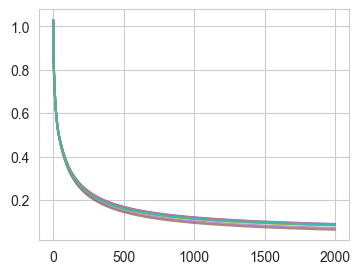

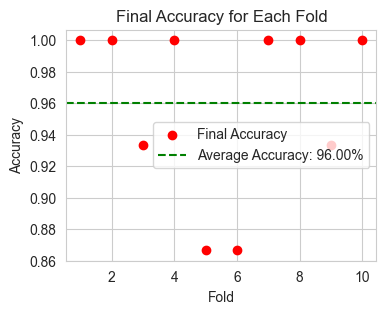

In [7]:
from matplotlib import pyplot as plt

# 设置超参数
learning_rate = 0.01
epochs = 2000
hidden_layer_sizes = [1]  # 调整隐藏层的数量和神经元数量

# 10次10折交叉验证
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
plt.figure(figsize=(4, 3))  # 新建一个图，设置图的大小

accuracies = []

for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"Fold {idx + 1}:")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 训练神经网络
    weights, biases, losses = train_neural_network(X_train, y_train, hidden_layer_sizes, learning_rate, epochs)

    # 可视化学习曲线
    plt.plot(range(epochs), losses, label=f'Fold {idx + 1}', alpha=0.7)  # 设置alpha以调整线的透明度

    # 预测
    predictions = predict(X_test, weights, biases)

    # 计算准确率
    accuracy = np.mean(predictions == y_test)
    print(f"Fold {idx + 1} Accuracy: {accuracy: .2%}\n")
    accuracies.append(accuracy)

# 打印平均准确率
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy:.2%}")

# 可视化每个fold的最终准确率
plt.figure(figsize=(4, 3))  # 新建一个图，设置图的大小
plt.scatter(range(1, 11), accuracies, color='red', marker='o', label='Final Accuracy')
plt.axhline(y=average_accuracy, color='green', linestyle='--', label=f'Average Accuracy: {average_accuracy:.2%}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Final Accuracy for Each Fold')
plt.legend()
plt.show()

Fold 1:
Epoch 0, Loss: 1.3885
Epoch 100, Loss: 0.1220
Epoch 200, Loss: 0.0764
Epoch 300, Loss: 0.0621
Epoch 400, Loss: 0.0554
Epoch 500, Loss: 0.0518
Epoch 600, Loss: 0.0496
Epoch 700, Loss: 0.0482
Epoch 800, Loss: 0.0473
Epoch 900, Loss: 0.0466
Epoch 1000, Loss: 0.0461
Epoch 1100, Loss: 0.0458
Epoch 1200, Loss: 0.0455
Epoch 1300, Loss: 0.0452
Epoch 1400, Loss: 0.0450
Epoch 1500, Loss: 0.0448
Epoch 1600, Loss: 0.0446
Epoch 1700, Loss: 0.0444
Epoch 1800, Loss: 0.0442
Epoch 1900, Loss: 0.0440
Fold 1 Accuracy:  100.00%

Fold 2:
Epoch 0, Loss: 1.3961
Epoch 100, Loss: 0.1199
Epoch 200, Loss: 0.0736
Epoch 300, Loss: 0.0591
Epoch 400, Loss: 0.0523
Epoch 500, Loss: 0.0486
Epoch 600, Loss: 0.0464
Epoch 700, Loss: 0.0450
Epoch 800, Loss: 0.0440
Epoch 900, Loss: 0.0433
Epoch 1000, Loss: 0.0427
Epoch 1100, Loss: 0.0423
Epoch 1200, Loss: 0.0420
Epoch 1300, Loss: 0.0417
Epoch 1400, Loss: 0.0415
Epoch 1500, Loss: 0.0412
Epoch 1600, Loss: 0.0410
Epoch 1700, Loss: 0.0408
Epoch 1800, Loss: 0.0406
Epoch 

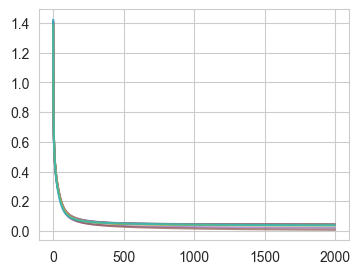

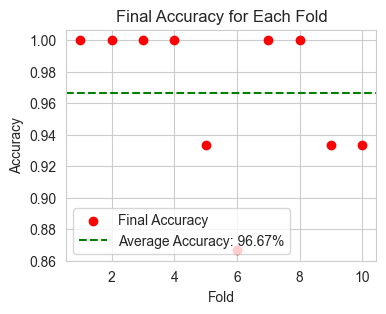

In [8]:
from matplotlib import pyplot as plt

# 设置超参数
learning_rate = 0.01
epochs = 2000
hidden_layer_sizes = [6]  # 调整隐藏层的数量和神经元数量

plt.figure(figsize=(4, 3))  # 新建一个图，设置图的大小

accuracies = []

for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"Fold {idx + 1}:")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 训练神经网络
    weights, biases, losses = train_neural_network(X_train, y_train, hidden_layer_sizes, learning_rate, epochs)

    # 可视化学习曲线
    plt.plot(range(epochs), losses, label=f'Fold {idx + 1}', alpha=0.7)  # 设置alpha以调整线的透明度

    # 预测
    predictions = predict(X_test, weights, biases)

    # 计算准确率
    accuracy = np.mean(predictions == y_test)
    print(f"Fold {idx + 1} Accuracy: {accuracy: .2%}\n")
    accuracies.append(accuracy)

# 打印平均准确率
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy:.2%}")

# 可视化每个fold的最终准确率
plt.figure(figsize=(4, 3))  # 新建一个图，设置图的大小
plt.scatter(range(1, 11), accuracies, color='red', marker='o', label='Final Accuracy')
plt.axhline(y=average_accuracy, color='green', linestyle='--', label=f'Average Accuracy: {average_accuracy:.2%}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Final Accuracy for Each Fold')
plt.legend()
plt.show()

Fold 1:
Epoch 0, Loss: 1.2441
Epoch 100, Loss: 0.4111
Epoch 200, Loss: 0.1446
Epoch 300, Loss: 0.0782
Epoch 400, Loss: 0.0605
Epoch 500, Loss: 0.0540
Epoch 600, Loss: 0.0509
Epoch 700, Loss: 0.0493
Epoch 800, Loss: 0.0483
Epoch 900, Loss: 0.0477
Epoch 1000, Loss: 0.0472
Epoch 1100, Loss: 0.0468
Epoch 1200, Loss: 0.0465
Epoch 1300, Loss: 0.0462
Epoch 1400, Loss: 0.0459
Epoch 1500, Loss: 0.0457
Epoch 1600, Loss: 0.0454
Epoch 1700, Loss: 0.0452
Epoch 1800, Loss: 0.0450
Epoch 1900, Loss: 0.0447
Fold 1 Accuracy:  100.00%

Fold 2:
Epoch 0, Loss: 1.2452
Epoch 100, Loss: 0.4097
Epoch 200, Loss: 0.1366
Epoch 300, Loss: 0.0730
Epoch 400, Loss: 0.0564
Epoch 500, Loss: 0.0502
Epoch 600, Loss: 0.0474
Epoch 700, Loss: 0.0459
Epoch 800, Loss: 0.0450
Epoch 900, Loss: 0.0444
Epoch 1000, Loss: 0.0440
Epoch 1100, Loss: 0.0436
Epoch 1200, Loss: 0.0433
Epoch 1300, Loss: 0.0431
Epoch 1400, Loss: 0.0428
Epoch 1500, Loss: 0.0426
Epoch 1600, Loss: 0.0424
Epoch 1700, Loss: 0.0421
Epoch 1800, Loss: 0.0419
Epoch 

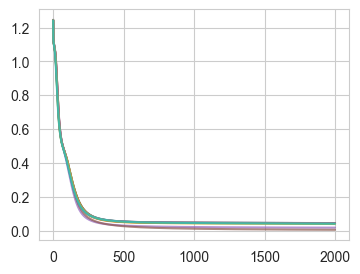

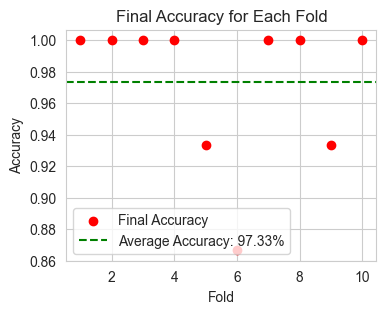

In [9]:
from matplotlib import pyplot as plt

# 设置超参数
learning_rate = 0.01
epochs = 2000
hidden_layer_sizes = [2, 3]  # 调整隐藏层的数量和神经元数量

# 10次10折交叉验证
plt.figure(figsize=(4, 3))  # 新建一个图，设置图的大小

accuracies = []

for idx, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"Fold {idx + 1}:")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # 训练神经网络
    weights, biases, losses = train_neural_network(X_train, y_train, hidden_layer_sizes, learning_rate, epochs)

    # 可视化学习曲线
    plt.plot(range(epochs), losses, label=f'Fold {idx + 1}', alpha=0.7)  # 设置alpha以调整线的透明度

    # 预测
    predictions = predict(X_test, weights, biases)

    # 计算准确率
    accuracy = np.mean(predictions == y_test)
    print(f"Fold {idx + 1} Accuracy: {accuracy: .2%}\n")
    accuracies.append(accuracy)

# 打印平均准确率
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy:.2%}")

# 可视化每个fold的最终准确率
plt.figure(figsize=(4, 3))  # 新建一个图，设置图的大小
plt.scatter(range(1, 11), accuracies, color='red', marker='o', label='Final Accuracy')
plt.axhline(y=average_accuracy, color='green', linestyle='--', label=f'Average Accuracy: {average_accuracy:.2%}')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Final Accuracy for Each Fold')
plt.legend()
plt.show()